In [0]:
# Import necessary libraries

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing of the Dataset

In [0]:
# Class to store the vocabulary of a language

SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
# Utility functions to normalize the words

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?।,])", r" \1", s)
    return s

In [0]:
# Load the English-to-Hindi sentence pairs from downloaded database [obtained from http://www.manythings.org/anki/]

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[0:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
# Preprocess the sentence pairs to be used for training
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'hin', False)
print(random.choice(pairs))

Reading lines...
Read 2778 sentence pairs
Counting words...
Counted words:
eng 2403
hin 2624
['he decided not to go to the party .', 'उसन पारटी म न जान का फसला किया ।']


In [7]:
# Store the maximum length of a sentence (Hindi or English) present in the dataset

MAX_LENGTH = 0
for pair in pairs:
    if len(pair[0].split(" ")) + 1 > MAX_LENGTH:
        MAX_LENGTH = len(pair[0].split(" ")) + 1
    if len(pair[1].split(" ")) + 1 > MAX_LENGTH:
        MAX_LENGTH = len(pair[1].split(" ")) + 1

MAX_LENGTH

29

## Define the Model Architecture

In [0]:
# Encoder using an embedding & GRU

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# Simple decoder using an embeding & GRU

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
# Decoder using attention mechanism

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training the Sequence to Sequence Machine Translation Model

In [0]:
# Utility functions to be used during training

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [0]:
# Use 'Teacher Forcing' mechanism to a desired degree for a single iteration of training

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
# Utility functions to calculate time taken

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
# Training of the model

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]

    # Use negative log likelihood as loss function
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [0]:
# Utility function to plot the loss during training phase

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

2m 33s (- 86m 50s) (5000 2%) 4.4364
4m 56s (- 81m 28s) (10000 5%) 3.7877
7m 21s (- 78m 33s) (15000 8%) 3.0571
9m 47s (- 75m 51s) (20000 11%) 2.3813
12m 14s (- 73m 24s) (25000 14%) 1.8458
14m 41s (- 71m 0s) (30000 17%) 1.4127
17m 11s (- 68m 44s) (35000 20%) 1.0998
19m 40s (- 66m 25s) (40000 22%) 0.8417
22m 12s (- 64m 9s) (45000 25%) 0.6733
24m 43s (- 61m 49s) (50000 28%) 0.5295
27m 17s (- 59m 32s) (55000 31%) 0.4480
29m 49s (- 57m 10s) (60000 34%) 0.3812
32m 22s (- 54m 46s) (65000 37%) 0.3178
34m 52s (- 52m 19s) (70000 40%) 0.2559
37m 25s (- 49m 53s) (75000 42%) 0.1904
39m 57s (- 47m 27s) (80000 45%) 0.1538
42m 29s (- 44m 59s) (85000 48%) 0.1479
45m 0s (- 42m 30s) (90000 51%) 0.1288
47m 32s (- 40m 2s) (95000 54%) 0.1126
50m 4s (- 37m 33s) (100000 57%) 0.1068
52m 36s (- 35m 4s) (105000 60%) 0.1008
55m 9s (- 32m 35s) (110000 62%) 0.0962
57m 41s (- 30m 5s) (115000 65%) 0.0987
60m 13s (- 27m 36s) (120000 68%) 0.0863
62m 46s (- 25m 6s) (125000 71%) 0.0851
65m 18s (- 22m 36s) (130000 74%) 0.0

<Figure size 432x288 with 0 Axes>

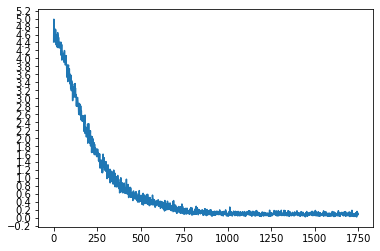

In [0]:
# Actual training of the model

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 175000, print_every=5000)

In [0]:
# Save the encoder & decoder (using attention) models

torch.save(encoder1.state_dict(), "eng_to_hin_encoder")
torch.save(attn_decoder1.state_dict(), "eng_to_hin_attn_decoder")

In [12]:
encoder1 = EncoderRNN(input_lang.n_words, 256).to(device)
encoder1.load_state_dict(torch.load('eng_to_hin_encoder'))

attn_decoder1 = AttnDecoderRNN(256, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder1.load_state_dict(torch.load('eng_to_hin_attn_decoder'))

<All keys matched successfully>

In [0]:
# Evaluate the performance of the model by translating an English sentence into HIndi

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
# Choose sentences  randomly from the dataset & run them through the model

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
# Results of random evaluation

evaluateRandomly(encoder1, attn_decoder1)

> nobody else offered to help .
= किसी और न मदद करन की इचछा परकट नही करी ।
< किसी और न मदद करन की इचछा परकट नही करी । <EOS>

> "who is it ?" "it's me ."
= "कौन ह ?" "म ह"
< "कौन ह ?" "म ह" <EOS>

> last night you forgot to turn off the radio , didn't you ?
= तम कल रात रडियो को बद करना भल गए थ ना ?
< तम कल रात रडियो को बद करना भल गए थ ना ? <EOS>

> are you at home ?
= तम घर प हो कया ?
< तम घर प हो कया ? <EOS>

> i'll attend .
= म आऊगा ।
< म आऊगा । <EOS>

> you reap what you sow .
= जसी करनी वसी भरनी ।
< कर भला तो हो भला । <EOS>

> it is no use asking me for money .
= मझस पस मागन म कोई फायदा नही ह ।
< मझस पस मागन म कोई फायदा नही ह । <EOS>

> i live in boston , too .
= म भी बॉसटन म ही रहता ह ।
< म भी बॉसटन म ही रहता ह । <EOS>

> he climbed the stairs .
= वह सीडियो पर चढ गया ।
< वह सीडियो पर चढ गया । <EOS>

> do you know your size ?
= कया आपको अपना नाप पता ह ?
< कया आपको अपना नाप पता ह ? <EOS>



In [0]:
# Function to plot the attention paid to input sequence for each of the outputs in the translated sentence

%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    
    # The y-labels are commented out because matplotlib doe not support Hindi fonts
    # ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

## Results

Following are some results obtained by the Sequence to Sequence translation model

input = please answer my questions .
output = मर सवालो का जवाब दो । <EOS>


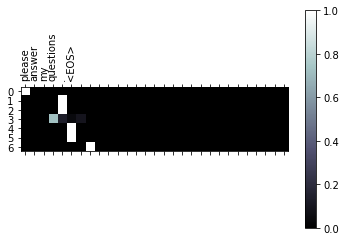

In [23]:
evaluateAndShowAttention("please answer my questions .")
# Pretty accurate

input = when will he come ?
output = वह कब आएगा कया ? <EOS>


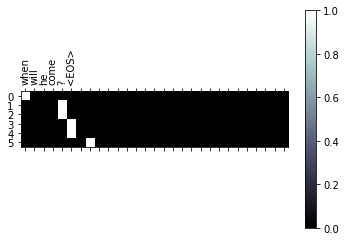

In [28]:
evaluateAndShowAttention("when will he come ?")
# Captures some context, but lacks grammatical correctness

input = people from france speak french .
output = सभी की सभी स नफरत ह । <EOS>


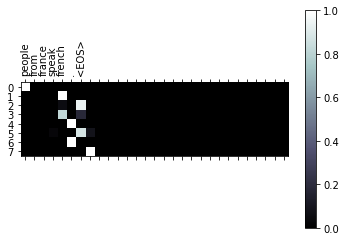

In [30]:
evaluateAndShowAttention("people from france speak french .")
# Sentence is structurally crrect, but far from actual translation

input = what am i supposed to do ?
output = आपको कया करना अचछा लगता ह ? <EOS>


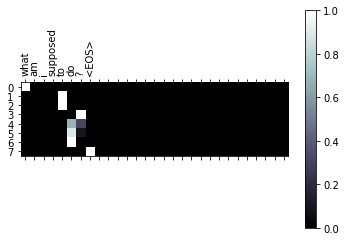

In [35]:
evaluateAndShowAttention("what am i supposed to do ?")
# Meaning closely related to actual translation, yet not correct

Given the minimal amount of data & lesser number of iterations available for training, the model is still able to produce Hindi senteces which are more or less gramatically correct, but may not be the best translation of the corresponding ENglish sentence.